In [ ]:
import io

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from neat.algo.genome import NodeType
from neat.networks.mlp import mlp

In [85]:
genome = mlp([2, 4, 8, 4, 2])

In [ ]:
# Build NetworkX graph for topological sorting
G = nx.DiGraph()

# Add nodes
for node_id, node in genome.nodes.items():
    G.add_node(
        node_id,
        **{
            "type": node.node_type,
            "activation": node.activation_function,
            "aggregation": node.aggregation_function,
            "bias": getattr(node, "bias", 0.0),
        },
    )

for connection in genome.connections.values():
    if connection.enabled:
        G.add_edge(connection.in_node_id, connection.out_node_id, weight=connection.weight)


In [ ]:
pos = {}

input_nodes = [node_id for node_id, node in genome.nodes.items() if node.node_type == NodeType.INPUT]
output_nodes = [node_id for node_id, node in genome.nodes.items() if node.node_type == NodeType.OUTPUT]

# Calculate layer depth for each node
layer_depth = {}

try:
    sorted_nodes = list(nx.topological_sort(G))
except nx.NetworkXUnfeasible:
    # Handle cyclic graphs if they can occur, e.g., for recurrent networks
    # For a simple feed-forward visualizer, we can error out or attempt a different layout
    print("Error: The graph has cycles and cannot be topologically sorted for layered layout.")
    # Fallback to a simpler layout if needed
    pos = nx.spring_layout(G) 
else:
    # Assign layer depth for input nodes
    for node in input_nodes:
        layer_depth[node] = 0

    # Assign layer depth for other nodes based on predecessors
    for node in sorted_nodes:
        if node not in layer_depth:
            preds = list(G.predecessors(node))
            if not preds:
                    layer_depth[node] = 0
            else:
                layer_depth[node] = max(layer_depth[p] for p in preds) + 1
    
    max_depth = max(layer_depth.values())

    # If all nodes are in one layer (e.g., inputs directly to outputs), prevent division by zero
    if max_depth == 0:
            max_depth = 1

    # Position nodes based on layer depth
    pos = {}
    nodes_by_layer = {}
    for node, depth in layer_depth.items():
        # Normalize depth to be the y-coordinate
        y = depth / max_depth
        if depth not in nodes_by_layer:
            nodes_by_layer[depth] = []
        nodes_by_layer[depth].append(node)
    
    for depth, nodes_in_layer in nodes_by_layer.items():
        y = depth / max_depth
        x_coords = np.linspace(0, 1, len(nodes_in_layer))
        for i, node in enumerate(sorted(nodes_in_layer)): # Sort for consistent ordering
            pos[node] = (x_coords[i], y)


In [ ]:
# Create a list of node colors
color_map = np.array(["black" for _ in range(len(G.nodes))])

color_map[input_nodes] = "blue"
color_map[output_nodes] = "red"

plt.figure(figsize=(7, 7))

# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_color="black", node_size=150)

# # Draw target and current nodes
nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_color="blue", node_size=150)
nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, node_color="red", node_size=150)

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
nx.draw_networkx_labels(G, pos, font_color="white", font_weight="bold", font_size=10)

plt.tight_layout()

# Save the plot to a BytesIO buffer
buf = io.BytesIO()
plt.savefig(buf, format="png")
plt.close()

# Convert buffer to PIL Image
buf.seek(0)
img = Image.open(buf)

img_array = np.array(img)

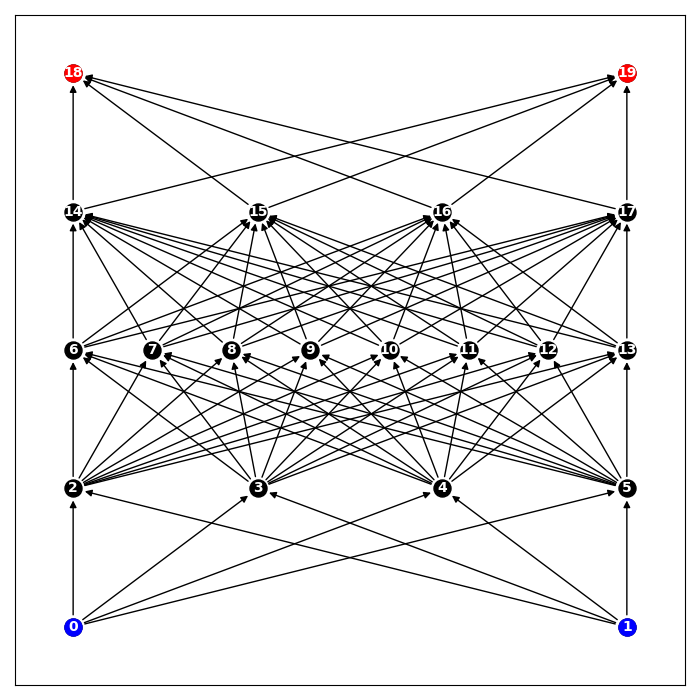

In [90]:
Image.fromarray(img_array)